I Installed the packages that I will need here.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")



Here I am Installing the dataset that I will use.

In [2]:

original_data = pd.read_csv('carDataset.csv')
data = original_data.copy()
data.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


I need to numberize the column named "name".

In [3]:

data['brand'] = data['name'].apply(lambda x: x.split()[0])  
data['model'] = data['name'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'Unknown')  
data.drop(columns=['name'], inplace=True)


And then I am creating brand and model values.

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder_brand = LabelEncoder()
label_encoder_model = LabelEncoder()

data['brand'] = label_encoder_brand.fit_transform(data['brand'])
data['model'] = label_encoder_model.fit_transform(data['model'])


In here I am filling the blanks in database with mean values of the columns.

In [5]:

data['mileage'] = data['mileage'].str.extract('(\d+\.\d+|\d+)').astype(float)
data['engine'] = data['engine'].str.extract('(\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract('(\d+\.\d+|\d+)').astype(float)
data['torque'] = data['torque'].str.extract('(\d+\.\d+|\d+)').astype(float)


data['mileage'].fillna(data['mileage'].mean(), inplace=True)
data['engine'].fillna(data['engine'].mean(), inplace=True)
data['max_power'].fillna(data['max_power'].mean(), inplace=True)
data['seats'].fillna(data['seats'].mode()[0], inplace=True)
data['torque'].fillna(data['torque'].mean(), inplace=True)
data['engine_ratio'] = data['engine'] / data['mileage']  
data['age'] = 2024 - data['year']  


data = pd.get_dummies(data, columns=['fuel', 'seller_type', 'transmission', 'owner'], drop_first=True)
data = data[(data['seats'] >= 3) & (data['seats'] <= 8)]


print(data.columns)  # Kalan sütunları kontrol edin


Index(['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power',
       'torque', 'seats', 'brand', 'model', 'engine_ratio', 'age',
       'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'transmission_Manual',
       'owner_Fourth & Above Owner', 'owner_Second Owner',
       'owner_Test Drive Car', 'owner_Third Owner'],
      dtype='object')


In here we have a codeblock to see our data in a statistical way. We will use these informations afterwords to apply the right numbers for filters.

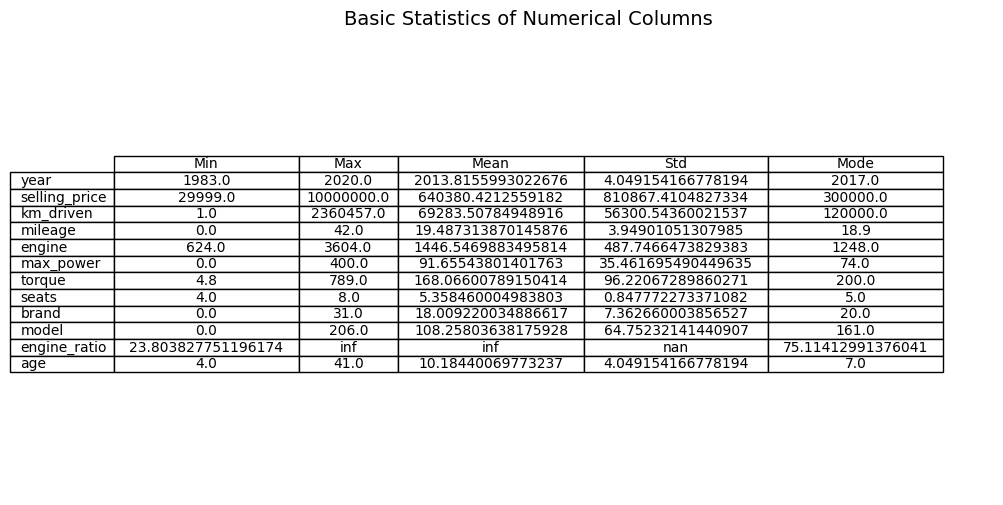

In [6]:
import matplotlib.pyplot as plt

numeric_columns = data.select_dtypes(include=['float64', 'int64'])
stats = numeric_columns.describe().T 
modes = numeric_columns.mode().iloc[0] 
stats['mode'] = modes  

fig, ax = plt.subplots(figsize=(12, 6))  
ax.axis('tight')  
ax.axis('off') 
table = ax.table(cellText=stats[['min', 'max', 'mean', 'std', 'mode']].values,
                 colLabels=['Min', 'Max', 'Mean', 'Std', 'Mode'],
                 rowLabels=stats.index,
                 loc='center',
                 cellLoc='center')  
table.auto_set_font_size(False) 
table.set_fontsize(10)  #
table.auto_set_column_width(col=list(range(len(stats.columns))))  

plt.title("Basic Statistics of Numerical Columns", fontsize=14)  
plt.show()


There is a codeline to see X counts under some specific circumstances.

In [7]:
count_2010_below = data[data['seats'] >4].shape[0]
print(f"Number of vehicles below the year 2010: {count_2010_below}")


Number of vehicles below the year 2010: 7893


We are applying IQR Fılter system in here to make our dataset more usable.

In [8]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns 
for column in numeric_columns:
    if column == 'seats': 
        continue
    
    Q1 = data[column].quantile(0.25)  
    Q3 = data[column].quantile(0.75)  
    IQR = Q3 - Q1 
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

print(f"Size of the filtered dataset: {data.shape}")


Size of the filtered dataset: (5720, 22)


In here we split the data in such a way that one part of it train data and the rest of it would be the test data.

In [9]:
data.shape

(5720, 22)

In [10]:
print(data['seats'].value_counts()) 


seats
5.0    5303
7.0     323
6.0      42
4.0      33
8.0      19
Name: count, dtype: int64


Let's create a correlation graphic to examine which features that we are using effects our model most

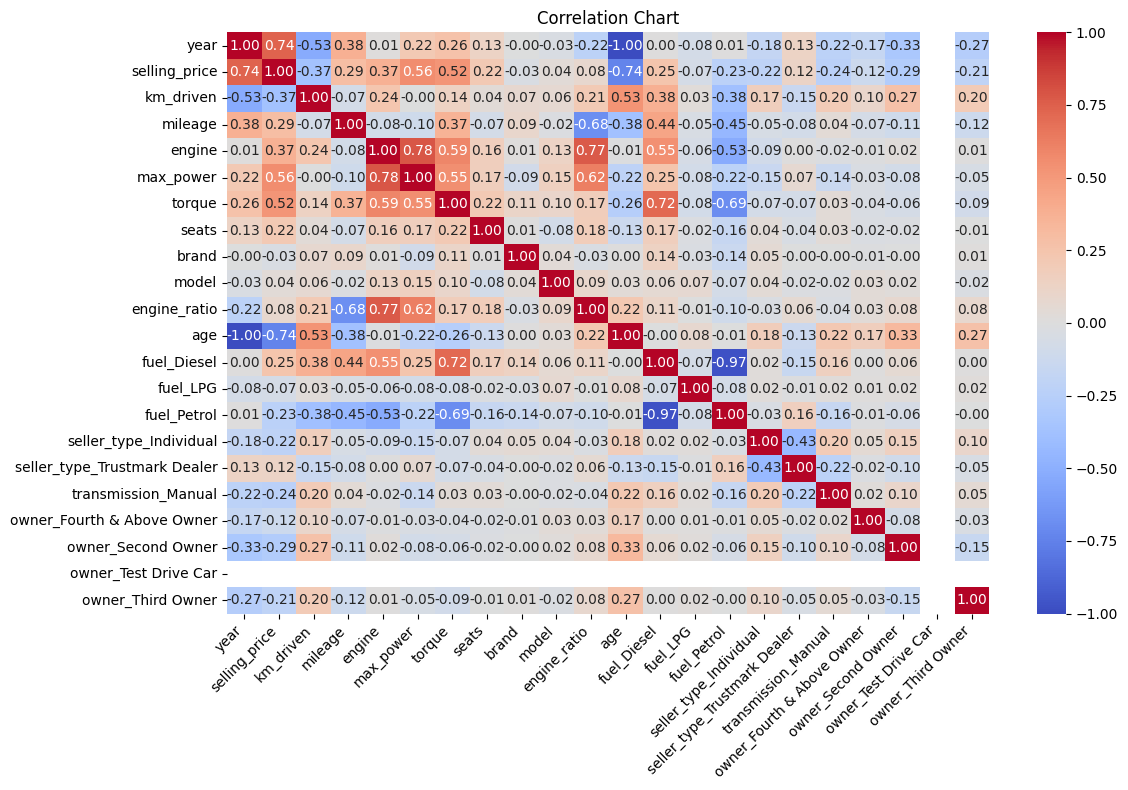

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Chart")
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)             
plt.tight_layout()
plt.show()

Now lets create our ANN model

We can choose what features the model will be able to use.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

X = data.drop(columns=['selling_price'])
y = data['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
important_features = feature_importance[feature_importance > 0.00001].index.tolist()  
print("Selected Important Features", important_features)

X_train = X_train[important_features]
X_test = X_test[important_features]

X_train_scaled = pd.DataFrame(index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(index=X_test.index, columns=X_test.columns)

problematic_columns = []  

for column in X_train.columns:
    try:
        transformer = PowerTransformer(method='yeo-johnson', standardize=True)
        X_train_scaled[column] = transformer.fit_transform(X_train[[column]])
        X_test_scaled[column] = transformer.transform(X_test[[column]])
    except Exception as e:
        print(f"{column} An error occurred in the column: {e}")
        problematic_columns.append(column)

print("Gaussian normalization is completed!")
print("Problematic Columns:", problematic_columns)


Selected Important Features ['year', 'age', 'max_power', 'torque', 'km_driven', 'model', 'mileage', 'brand', 'engine_ratio', 'engine', 'owner_Second Owner', 'seller_type_Individual', 'transmission_Manual', 'seats', 'owner_Third Owner', 'owner_Fourth & Above Owner', 'fuel_Diesel', 'fuel_Petrol', 'seller_type_Trustmark Dealer', 'fuel_LPG']
year An error occurred in the column: The algorithm terminated without finding a valid bracket. Consider trying different initial points.
Gaussian normalization is completed!
Problematic Columns: ['year']


Then we can visulize it by using plotlib.

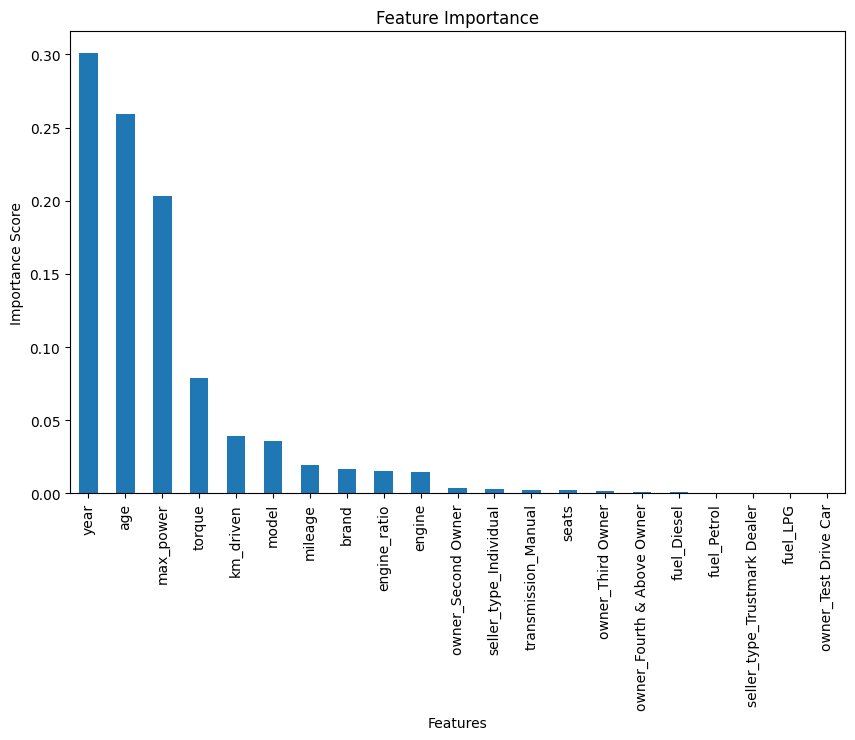

In [13]:
import matplotlib.pyplot as plt

feature_importance.plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

X_train_scaled = X_train_scaled.fillna(0).astype(float)
X_test_scaled = X_test_scaled.fillna(0).astype(float)
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Giriş katmanı
    Dense(64, activation='relu'),             # 1. gizli katman
    Dense(32, activation='relu'),             # 2. gizli katman
    Dense(32, activation='relu'),             # 3. gizli katman
    Dense(16, activation='relu'),             # 4. gizli katman
    Dense(1, activation='linear')             # Çıkış katmanı
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test),
                    epochs=180, batch_size=32, verbose=1)


Epoch 1/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 70.9803 - mae: 7.1240 - val_loss: 2.2454 - val_mae: 1.1797
Epoch 2/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 1.7520 - mae: 1.0357 - val_loss: 0.9254 - val_mae: 0.7548
Epoch 3/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.7705 - mae: 0.6894 - val_loss: 0.5317 - val_mae: 0.5635
Epoch 4/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.4343 - mae: 0.5136 - val_loss: 0.3505 - val_mae: 0.4502
Epoch 5/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.3078 - mae: 0.4225 - val_loss: 0.2759 - val_mae: 0.4084
Epoch 6/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.2253 - mae: 0.3664 - val_loss: 0.1923 - val_mae: 0.3296
Epoch 7/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.1628 - mae: 0.3108 - val_loss: 0.1601 - val_mae: 0.3003
Epoch 8/180
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.1351 - mae: 0.2788 - val_loss: 0.1305 - val_mae: 0.2700
Epoch 9/180
143/143 ━━━━━━━━━━━━━

In [15]:
print(X_train.isnull().sum())


year                            0
age                             0
max_power                       0
torque                          0
km_driven                       0
model                           0
mileage                         0
brand                           0
engine_ratio                    0
engine                          0
owner_Second Owner              0
seller_type_Individual          0
transmission_Manual             0
seats                           0
owner_Third Owner               0
owner_Fourth & Above Owner      0
fuel_Diesel                     0
fuel_Petrol                     0
seller_type_Trustmark Dealer    0
fuel_LPG                        0
dtype: int64


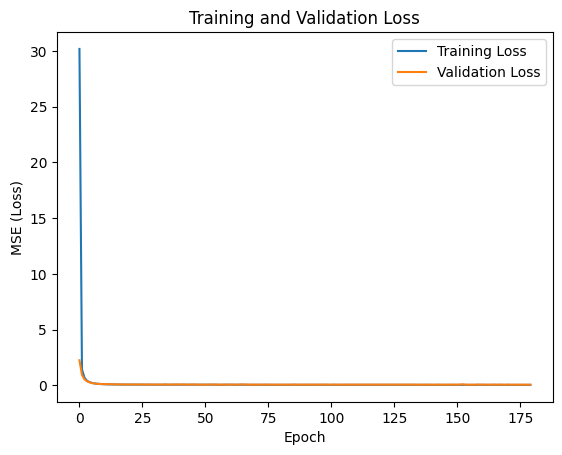

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (Loss)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [17]:
train_loss, train_mae = model.evaluate(X_train_scaled, y_train, verbose=0)
print(f"Training Loss (MSE): {train_loss}")
print(f"Training Error (MAE): {train_mae}")

test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_mae}")

y_train_pred = model.predict(X_train_scaled)
train_mape = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
train_accuracy = 100 - train_mape
print(f"Training Accuracy Percentage: {train_accuracy:.2f}%")

y_test_pred = model.predict(X_test_scaled)
test_mape = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100
test_accuracy = 100 - test_mape
print(f"Test Accuracy Percentage: {test_accuracy:.2f}%")

Training Loss (MSE): 0.03079988621175289
Training Error (MAE): 0.13253991305828094
Test Loss (MSE): 0.051961660385131836
Test Error (MAE): 0.1638614535331726
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
Training Accuracy Percentage: 98.95%
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
Test Accuracy Percentage: 98.70%
